In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from utils import generate_matrix, batch_dirichlet, get_similarities, plot_similarities, get_differences, plot_differences, get_images, plot_images

from models.vit_old import ViT, SimpleViT, SimpleViTI, SimpleViTFT, adjacency

from sklearn.metrics.pairwise import cosine_similarity

In [6]:
method = "SimpleViT"

augment = True
batch_size = 1
size = 32
patch_size = 1
depth = 32
dim = 3
device = 'cuda:0'
data_path = '/home/gbetondji/smoothtransformer/data/'

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def generate_matrix(dim,sign=1):
    #V = np.diag(sign*np.random.rand(dim))
    #Q = np.random.normal(0,0.1,(dim,dim))
    #return Q@V@np.linalg.inv(Q)
    Wp = np.random.normal(0,0.1,(dim,dim))
    W0 = 0.5*(Wp+Wp.T)
    W = sign* W0@W0.T
    return W

def diffusion_step(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A,np.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

In [19]:
a_shape = (size//patch_size*size//patch_size,size//patch_size*size//patch_size)
As =[
    #scipy.special.softmax(np.random.normal(0,1,a_shape), axis=0) for _ in range(n_steps)
    (np.ones(a_shape) - np.eye(a_shape[0]))/(a_shape[0]-1) for _ in range(depth)
]

#As = [adjacency(a_shape[0])]*depth

Ws =[
    #scipy.special.softmax(np.random.normal(0,0.1,w_shape), axis=1)/w_shape[1] for _ in range(n_steps)
    scipy.special.softmax(generate_matrix(dim,-1), axis=-1)/dim for _ in range(depth)
    #generate_matrix(dim,-1) for _ in range(depth)
]

In [21]:
np.linalg.eig(Ws[0])[0]

array([ 3.33333333e-01, -1.21620067e-03, -1.81485239e-04])

In [114]:
model_bases = {
    'SimpleViT':SimpleViT,
    'SimpleViTI':SimpleViTI,
    'SimpleViTFT':SimpleViTFT,
    'ViT':ViT
}

def get_output(data_batch,method):
    model = model_bases[method](
        image_size = size,
        patch_size = patch_size,
        num_classes = 10,
        dim = dim,
        depth = depth,
        heads = 1,
        mlp_dim = 1024,
        dropout = 0.,
        emb_dropout = 0.,
        pool = 'mean'
    )
    model = model.to(device)
    
    x0 = model.to_patch_embedding(data_batch)
    outputs = [x0.detach().cpu().numpy()]
    
    for container in model.transformer.children():
        #for step,attention_layer in enumerate(container):
        #    outputs.append(attention_layer(outputs[-1])) 
        for A,W in zip(As,Ws):
            outputs.append(diffusion_step(outputs[-1],A,W,0.5))
            
    for i in range(len(outputs)):
        outputs[i] = outputs[i]#.detach().cpu().numpy()
            
    return outputs

In [115]:
data_batch = next(iter(val_loader))[0].to(device)
data_batch.shape

torch.Size([1, 3, 32, 32])

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [116]:
outputs = get_output(data_batch,'SimpleViTI')

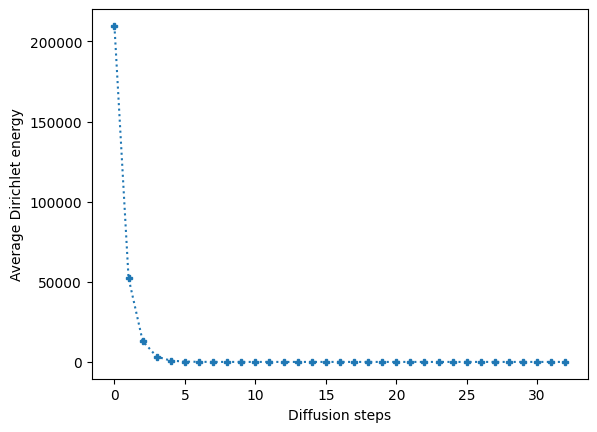

In [117]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

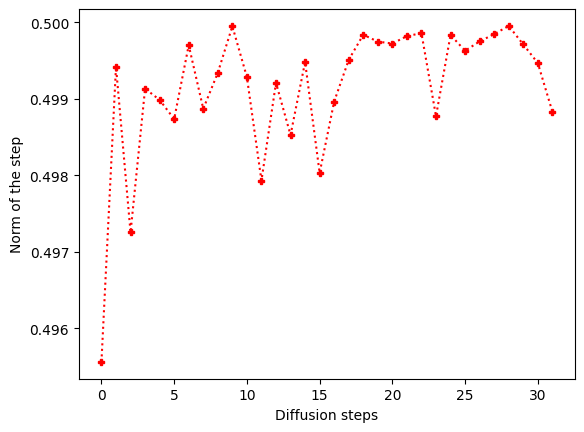

In [118]:
differences = get_differences(outputs)
plot_differences(differences)

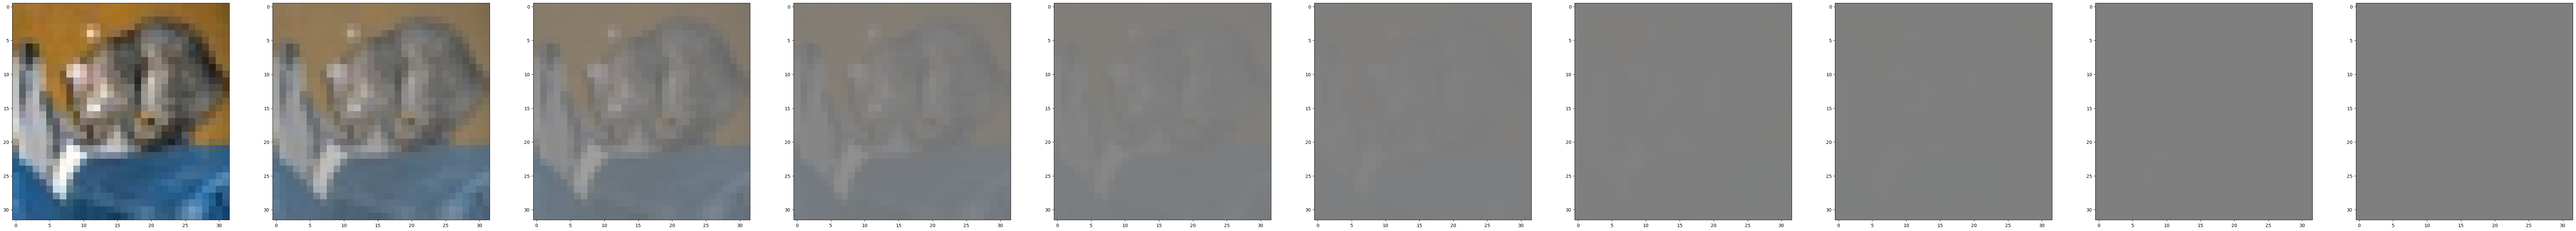

In [119]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images(images)

## $\mathbf{F}(t+1) = \tau \bar{\mathbf{A}}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [21]:
outputs = get_output(data_batch,'SimpleViTI')

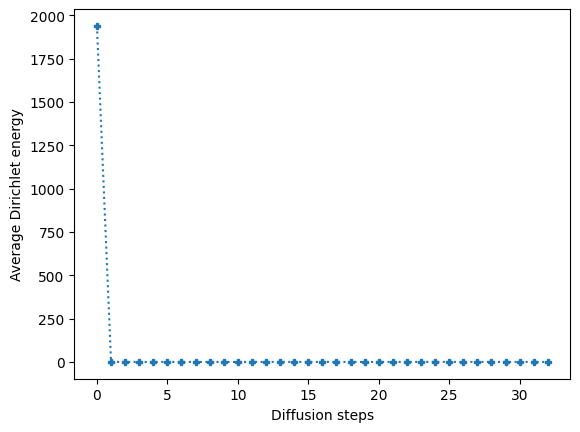

In [22]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

/home/gbetondji/smoothtransformer/utils.py:61: RuntimeWarning: invalid value encountered in float_scalars
  differences.append(np.linalg.norm(outputs[k+1])/np.linalg.norm(outputs[k]))


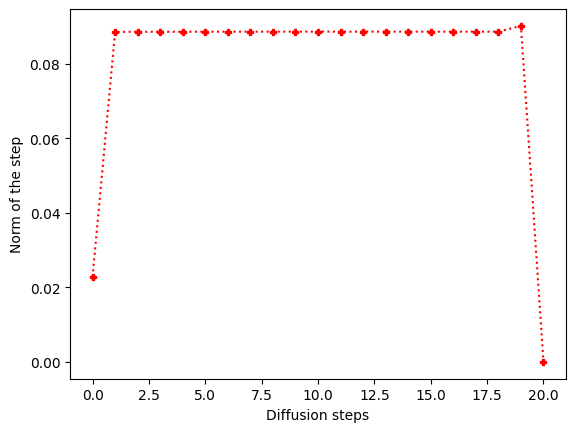

In [8]:
differences = get_differences(outputs)
plot_differences(differences)

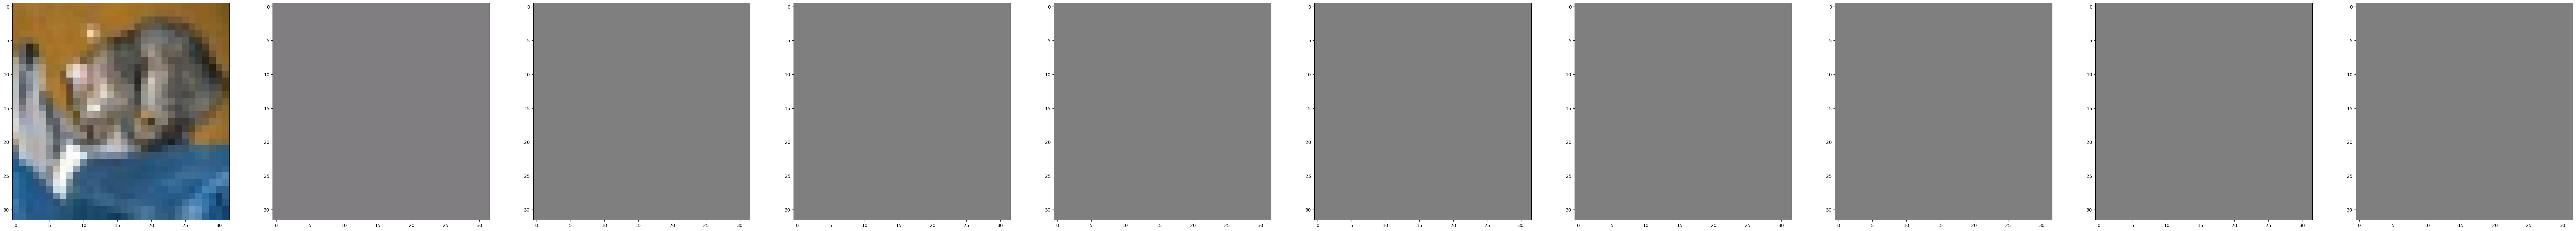

In [9]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images(images)

### Channel mixing matrix with negative eigenvalues

In [6]:
outputs = get_output(data_batch,'SimpleViTI')

TypeError: get_output() takes 2 positional arguments but 3 were given

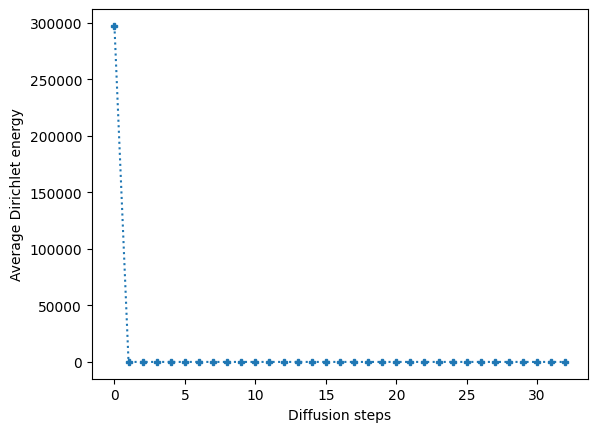

In [7]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

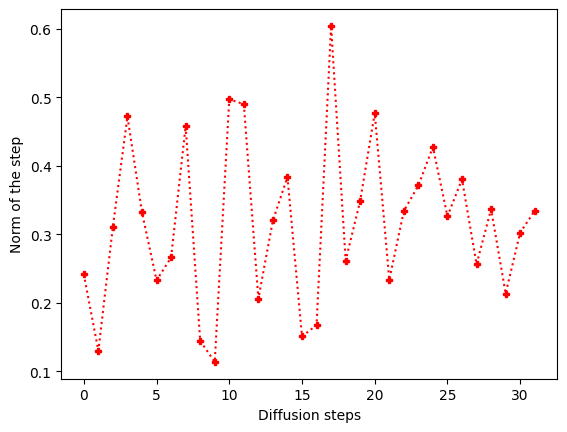

In [8]:
differences = get_differences(outputs)
plot_differences(differences)

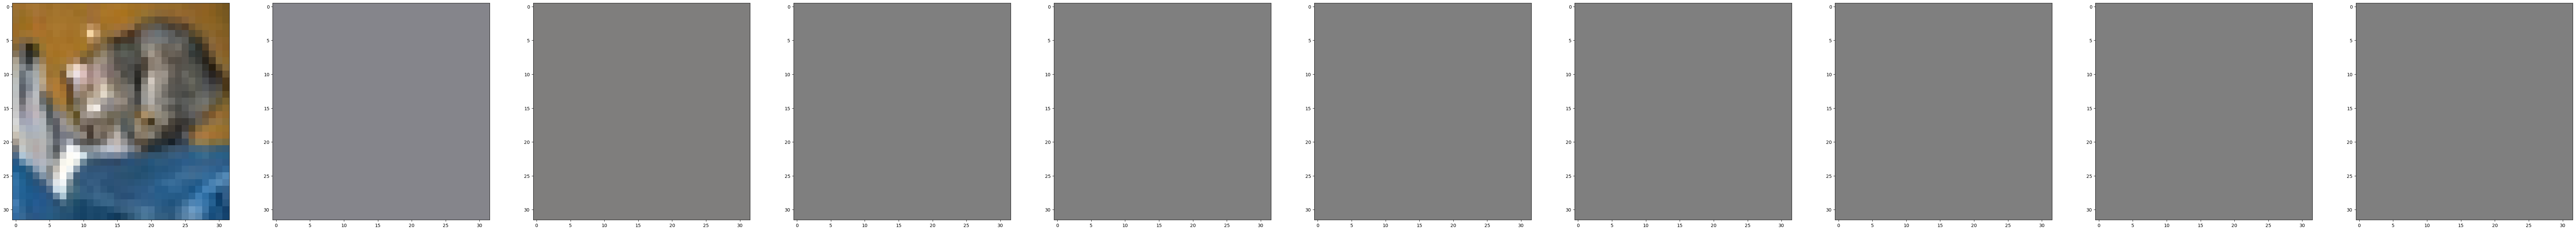

In [9]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images(images)

## $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + (1 - \tau) \mathbf{F}(t)$

In [10]:
outputs = get_output(data_batch,'SimpleViTFT',False)

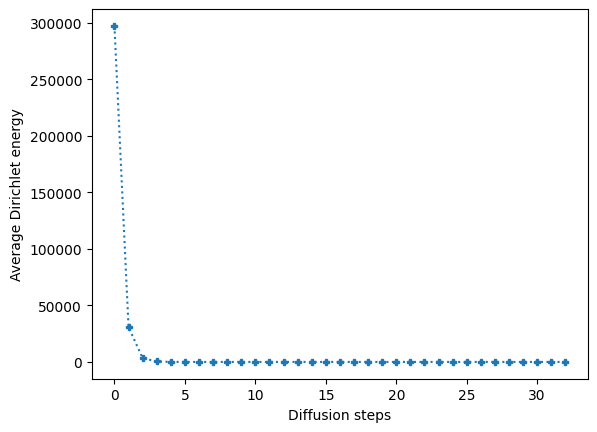

In [11]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

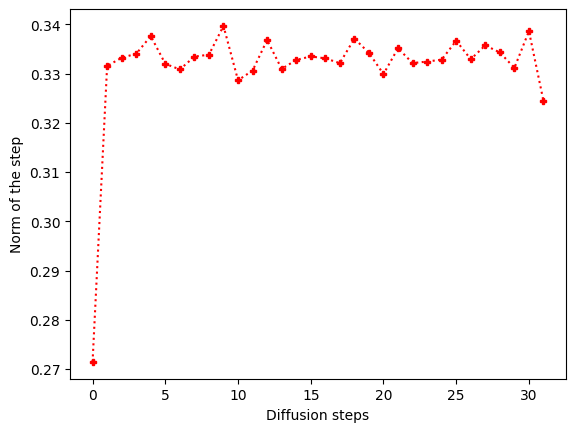

In [12]:
differences = get_differences(outputs)
plot_differences(differences)

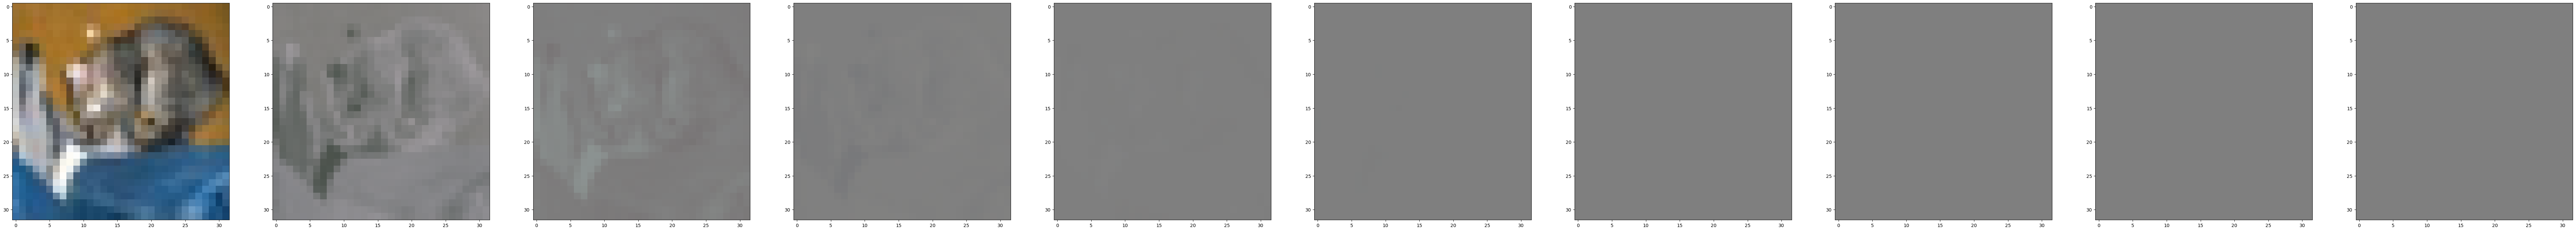

In [108]:
if patch_size == 1 and dim==3:
    images = get_images(outputs)
    plot_images(images)